In [1]:
# ---------------------------------------------------------
#   Unsupervised Learning (Clustering Professors)
# ---------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Load the Data
# We use the file that has both comments AND numerical ratings
df = pd.read_csv('../data/processed/sentiment_data.csv')

print("Data Loaded!")
print("Columns available:", df.columns.tolist())

# 2. Check for Numeric Scores
# We look for columns that likely contain ratings (usually 0-5 or 0-20)
potential_score_cols = [col for col in df.columns if 'score' in col or 'rate' in col or 'quality' in col or 'difficulty' in col]
print("\nFound potential score columns:", potential_score_cols)

Data Loaded!
Columns available: ['id', 'date', 'professor_name_raw', 'department', 'course_name', 'term', 'comment_text', 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6', 'clean_department', 'clean_comment_text', 'professor_name', 'grading_status', 'attendance_status', 'clean_tokens_list', 'simple_label', 'simple_score', 'bert_label', 'bert_score']

Found potential score columns: ['simple_score', 'bert_score']


In [4]:
# ---------------------------------------------------------
#                 Feature Engineering
# ---------------------------------------------------------

# 1. Create 3 separate columns for sentiment
# We turn the text labels into numbers we can average
df['is_pos'] = (df['bert_label'] == 'Positive').astype(int)
df['is_neg'] = (df['bert_label'] == 'Negative').astype(int)
df['is_neu'] = (df['bert_label'] == 'Neutral').astype(int)

# 2. Convert Ratings to Numeric (Safety check)
score_cols = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6']
for col in score_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# 3. Aggregation: Group by Professor
# The 'mean' of a 0/1 column automatically gives us the PERCENTAGE.
prof_profile = df.groupby('professor_name').agg({
    'rating_1': 'mean',
    'rating_2': 'mean',
    'rating_3': 'mean',
    'rating_4': 'mean',
    'rating_5': 'mean',
    'rating_6': 'mean',
    'is_pos': 'mean',  # e.g., 0.60 = 60% Positive
    'is_neg': 'mean',  # e.g., 0.20 = 20% Negative
    'is_neu': 'mean',  # e.g., 0.20 = 20% Neutral
    'id': 'count'
}).rename(columns={'id': 'comment_count'})

# 4. Filter: Keep professors with at least 5 comments
prof_profile = prof_profile[prof_profile['comment_count'] >= 5].copy()

print("Advanced Profiles Built")
print(f"Total Professors to Cluster: {len(prof_profile)}")
display(prof_profile.head(10))

Advanced Profiles Built
Total Professors to Cluster: 293


,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,is_pos,is_neg,is_neu,comment_count
professor_name,,,,,,,,,,
ابراهیم اردشیر لاریجانی,6.250000,6.375000,4.875000,7.250000,6.625000,7.250000,0.125000,0.750000,0.125000,8
ابوالفضل اسکندری,3.615385,4.307692,3.153846,4.076923,4.769231,3.000000,0.384615,0.615385,0.000000,13
ابوذر غفاری,9.125000,9.875000,8.125000,6.500000,7.750000,9.250000,0.200000,0.300000,0.500000,10
احسان دهقانی برسیانی,8.000000,9.000000,6.750000,8.625000,8.250000,8.000000,0.625000,0.250000,0.125000,8
احمد رضا شاه علی,8.000000,8.481481,7.888889,8.481481,7.555556,7.962963,0.343750,0.375000,0.281250,32
احمد رضا فروغ,6.170732,7.682927,3.926829,6.487805,6.195122,7.658537,0.317073,0.439024,0.243902,41
احمدی,7.200000,8.200000,8.400000,9.400000,7.200000,9.600000,0.375000,0.250000,0.375000,8
اسدالله اقاجانی,9.200000,9.500000,9.000000,9.000000,8.800000,8.600000,0.600000,0.400000,0.000000,10
اسماء سلیمانی,9.600000,9.800000,9.400000,9.400000,10.000000,10.000000,0.800000,0.200000,0.000000,5


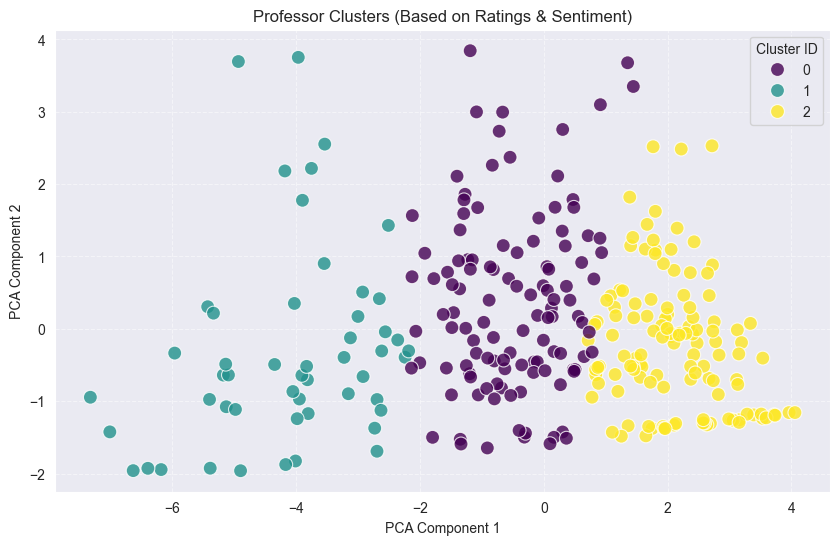

Cluster Interpretation (Average Scores per Group):


,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,is_pos,is_neg,is_neu
cluster,,,,,,,,,
0,7.604780,8.097275,6.743272,7.342047,7.158434,8.153273,0.358034,0.346181,0.295785
1,5.032149,5.493562,3.964179,4.909178,4.749629,5.965533,0.211253,0.555906,0.232841
2,9.055531,9.306112,8.846007,8.952531,9.004717,9.441732,0.626322,0.199495,0.174183


In [5]:
# ---------------------------------------------------------
#          K-Means Clustering & Visualization
# ---------------------------------------------------------
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# 1. Select Features (Ratings + 3 Sentiment Percentages)
score_cols = ['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5', 'rating_6']
features = score_cols + ['is_pos', 'is_neg', 'is_neu']

# Fill NaNs with 0 just in case
X = prof_profile[features].fillna(0)

# 2. Scale the Data
# (Crucial: Ratings are 0-10, but Sentiment is 0-1. Scaling makes them equal.)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Find Clusters (3 Groups)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
prof_profile['cluster'] = kmeans.fit_predict(X_scaled)

# 4. PCA for Visualization (Squash 9 dimensions -> 2D)
pca = PCA(n_components=2)
pca_components = pca.fit_transform(X_scaled)
prof_profile['pca_x'] = pca_components[:, 0]
prof_profile['pca_y'] = pca_components[:, 1]

# 5. Visualize
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=prof_profile, 
    x='pca_x', 
    y='pca_y', 
    hue='cluster', 
    palette='viridis', 
    s=100, 
    alpha=0.8
)
plt.title('Professor Clusters (Based on Ratings & Sentiment)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster ID')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# 6. Interpret the Groups
# This table is the KEY result. It tells us what the groups mean.
print("Cluster Interpretation (Average Scores per Group):")
display(prof_profile.groupby('cluster')[features].mean())

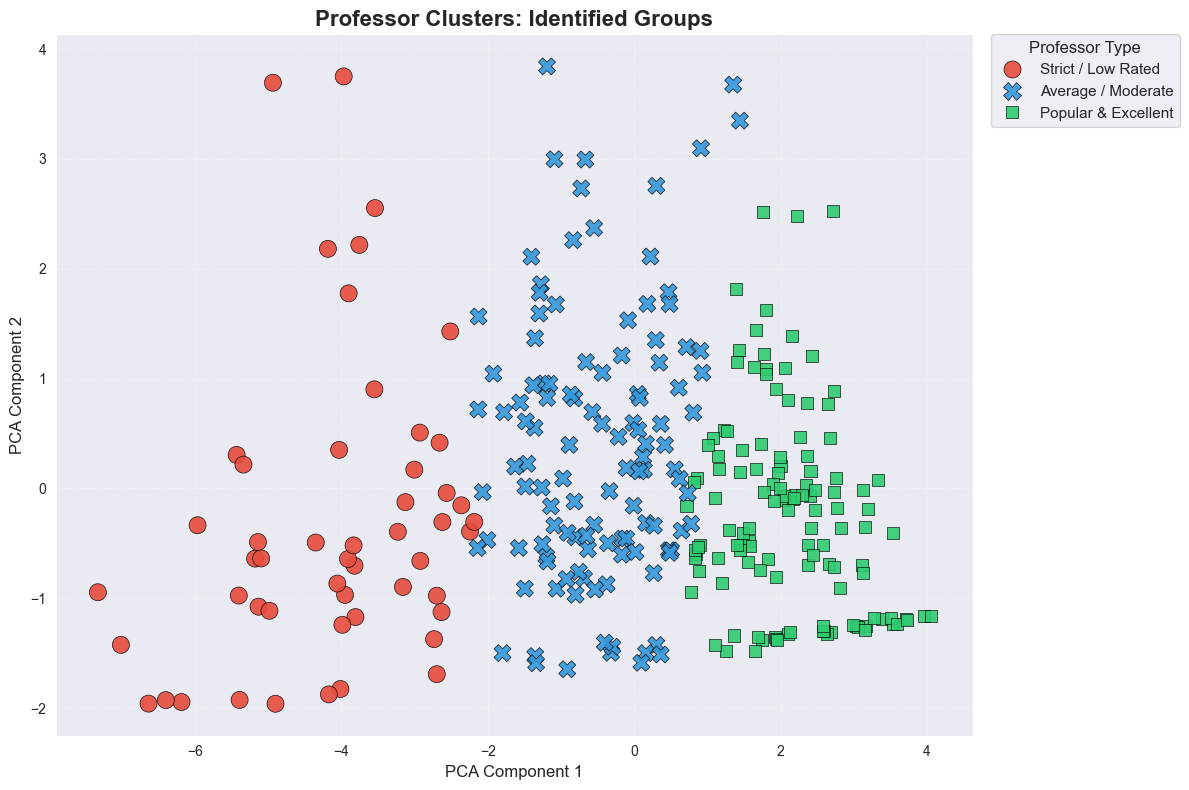

In [7]:
# ---------------------------------------------------------
#                 FINAL VISUALIZATION
# ---------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Map Cluster Numbers to Names (Based on your analysis)
cluster_names = {
    2: 'Popular & Excellent',   # The Best Group
    0: 'Average / Moderate',    # The Middle Group
    1: 'Strict / Low Rated'     # The Difficult Group
}

# 2. Define Custom Colors (High Contrast)
# Green for Good, Blue for Average, Red for Strict
custom_palette = {
    'Popular & Excellent': '#2ecc71',  # Bright Green
    'Average / Moderate':  '#3498db',  # Bright Blue
    'Strict / Low Rated':  '#e74c3c'   # Bright Red
}

# 3. Apply Names
prof_profile['cluster_label'] = prof_profile['cluster'].map(cluster_names)

# 4. Plot with Custom Colors
plt.figure(figsize=(12, 8)) # Made it slightly bigger
sns.scatterplot(
    data=prof_profile, 
    x='pca_x', 
    y='pca_y', 
    hue='cluster_label', 
    style='cluster_label', 
    palette=custom_palette,
    s=150,
    alpha=0.9,
    edgecolor='black', 
    linewidth=0.5
)

plt.title('Professor Clusters: Identified Groups', fontsize=16, fontweight='bold')
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.legend(title='Professor Type', title_fontsize=12, fontsize=11, 
           bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

🤖 Running Agglomerative Clustering...


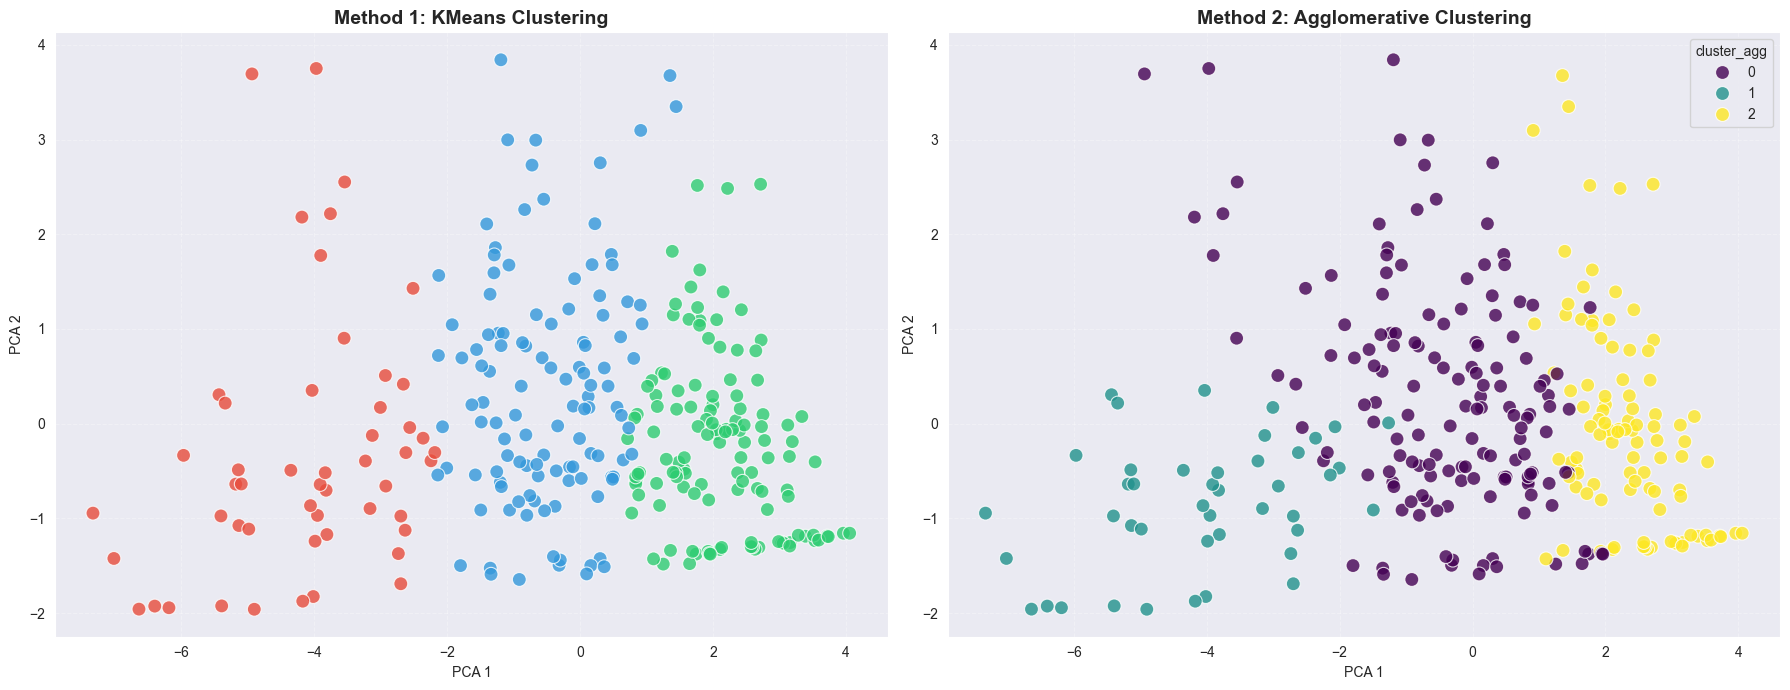

Agglomerative Cluster Interpretation:


,rating_1,rating_2,rating_3,rating_4,rating_5,rating_6,is_pos,is_neg,is_neu
cluster_agg,,,,,,,,,
0,7.568523,8.048702,6.745667,7.367530,7.249061,8.248435,0.381344,0.339185,0.279471
1,5.218550,5.614637,4.200251,5.013944,4.741594,5.645781,0.228032,0.622516,0.149451
2,9.169136,9.405769,9.019803,9.059513,9.122100,9.570031,0.637040,0.163500,0.199459


In [8]:
# ---------------------------------------------------------
#              Agglomerative Clustering
# ---------------------------------------------------------
from sklearn.cluster import AgglomerativeClustering

# 1. Run Agglomerative Clustering
# We use the same 'X_scaled' data we prepared earlier
agg_model = AgglomerativeClustering(n_clusters=3)
prof_profile['cluster_agg'] = agg_model.fit_predict(X_scaled)

# 2. Visualize Comparison (KMeans vs Agglomerative)
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: KMeans (The one we just did)
sns.scatterplot(
    data=prof_profile, x='pca_x', y='pca_y', hue='cluster_label', 
    palette=custom_palette, s=100, alpha=0.8, ax=axes[0], legend=False
)
axes[0].set_title('Method 1: KMeans Clustering', fontsize=14, fontweight='bold')
axes[0].set_xlabel('PCA 1')
axes[0].set_ylabel('PCA 2')
axes[0].grid(True, linestyle='--', alpha=0.3)

# Plot 2: Agglomerative (The new one)
# We let Seaborn pick colors since we haven't named these new clusters yet
sns.scatterplot(
    data=prof_profile, x='pca_x', y='pca_y', hue='cluster_agg', 
    palette='viridis', s=100, alpha=0.8, ax=axes[1]
)
axes[1].set_title('Method 2: Agglomerative Clustering', fontsize=14, fontweight='bold')
axes[1].set_xlabel('PCA 1')
axes[1].set_ylabel('PCA 2')
axes[1].grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Interpret the Agglomerative Groups
print("Agglomerative Cluster Interpretation:")
display(prof_profile.groupby('cluster_agg')[features].mean())